# lib

In [1]:
import pickle
# import warnings
# warnings.filterwarnings('ignore')
# import os
import pandas as pd
import numpy as np
# import math
# import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler , StandardScaler

# from itertools import product
# import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, ConvLSTM1D, Conv1D, Concatenate, Bidirectional
from tensorflow.keras.layers import LSTM , BatchNormalization, AveragePooling1D, Flatten, GRU, SimpleRNN

# from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# creat data lstm

In [2]:
with open('btc_stan.moh','rb') as f :
    btc = pickle.load(f)

In [3]:
btc = pd.read_csv('btc.csv',skiprows=1)
btc = btc[::-1].reset_index()
btcc = np.log(btc['close'])
btc = pd.DataFrame()
btc['close_log'] = btcc
btc['target_log'] = btc['close_log'].shift(-1)
btc = btc.dropna()

scaler = MinMaxScaler(feature_range=(0, 1))
btc.close_log = scaler.fit_transform(btc.close_log.values.reshape(-1,1))
btc.target_log = scaler.transform(btc.target_log.values.reshape(-1,1))


btc.head(2)

,close_log,target_log
0,0.139684,0.139878
1,0.139878,0.138384


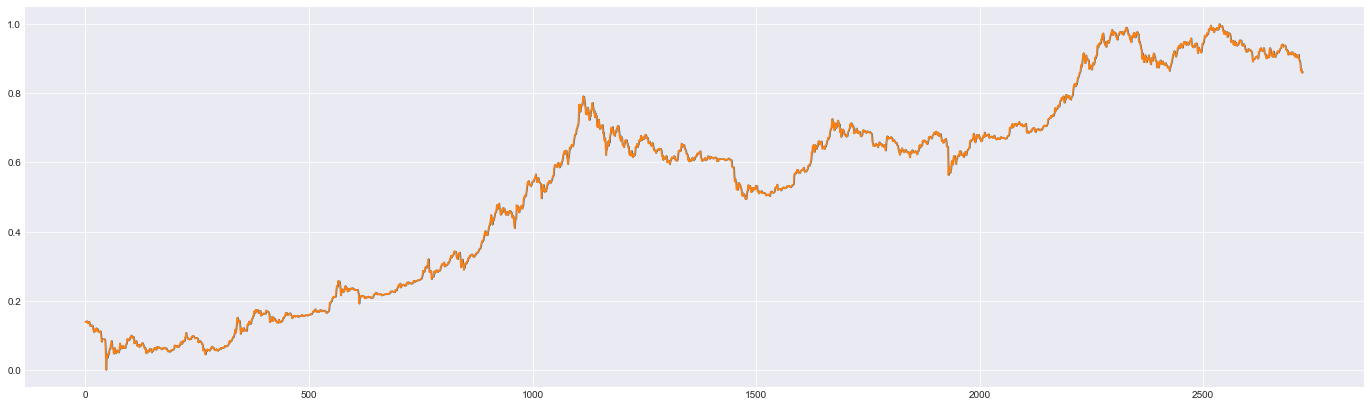

In [4]:
plt.figure(figsize=(24,7))
plt.plot(btc)

In [5]:
look_back_ = 365
prediction_days = 60
future_ = 30


df_train_= btc[:][:len(btc)-(prediction_days+future_)]#values.reshape(-1,1)

df_test_= btc[:][len(btc)-(prediction_days+future_+look_back_-1):len(btc)-future_]#.values.reshape(-1,1)

future_ = btc[:][len(btc)-(future_+look_back_-1):]

In [6]:
df_train_.columns

Index(['close_log', 'target_log'], dtype='object')

In [7]:
col = df_train_.columns
df_train = df_train_[:][col]
df_test = df_test_[:][col]
future = future_[:][col]
df_test.head(2)

,close_log,target_log
2270,0.945618,0.943148
2271,0.943148,0.947326


In [8]:
# # many to one

# from collections import deque
# def dataset_generator_lstm(dataset, look_back=look_back_):
#   sequential_data = [] 
#   prev_days = deque(maxlen=look_back)
#   for i in dataset.values:
#     prev_days.append([n for n in i[:-1]])
#     if len(prev_days) == look_back:  
#       sequential_data.append([np.array(prev_days), i[-1]])
#   dataX=[]
#   dataY=[]
#   for seq, target in sequential_data: 
#     dataX.append(seq) 
#     dataY.append(target) 
#   return np.array(dataX), np.array(dataY)

# trainX, trainY = dataset_generator_lstm(df_train)

# testX, testY = dataset_generator_lstm(df_test)
# # trainX, trainY = trainX[:1740], trainY[:1740]

# futureX, futureY = dataset_generator_lstm(future)

# print("trainX: ", trainX.shape)
# print("trainY: ", trainY.shape)
# print("testX: ", testX.shape)
# print("testY", testY.shape)
# print("futureX: ", futureX.shape)
# print("futureY", futureY.shape)

In [9]:
# many to one

from collections import deque
def dataset_generator_lstm(dataset, look_back=look_back_):
    sequential_data = [] 
    prev_days = deque(maxlen=look_back)
    for i in dataset.values:
        prev_days.append([n for n in i[:-1]])
        if len(prev_days) == look_back:  
            sequential_data.append([np.array(prev_days), i[-1]])
    dataX=[]
    dataY=[]
    for seq, target in sequential_data: 
        dataX.append(seq) 
        dataY.append(target) 
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(df_train)

testX, testY = dataset_generator_lstm(df_test)

futureX, futureY = dataset_generator_lstm(future)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)
print("futureX: ", futureX.shape)
print("futureY", futureY.shape)

trainX:  (2270, 365, 1)
trainY:  (2270,)
testX:  (60, 365, 1)
testY (60,)
futureX:  (30, 365, 1)
futureY (30,)


# train

In [10]:
# batch_size = 60

# regressor = Sequential()

# regressor.add(LSTM(units = 256, activation = 'relu', return_sequences=True, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True)) #  dropout=0.25, recurrent_dropout=0.1,
# regressor.add(Dropout(0.2))

# regressor.add(LSTM(units = 512, activation = 'relu', return_sequences=True, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True)) #  dropout=0.25, recurrent_dropout=0.1,
# regressor.add(Dropout(0.3))

# regressor.add(LSTM(units = 1024, activation = 'relu', return_sequences=True, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True)) #  dropout=0.25, recurrent_dropout=0.1,
# regressor.add(Dropout(0.4))

# regressor.add(LSTM(units = 128, activation = 'relu', batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True))
# regressor.add(Dropout(0.2))


# regressor.add(Dense(units = 32, activation = 'relu'))
# regressor.add(Dropout(0.3))

# regressor.add(Dense(units = 1))

input1 = Input(shape=trainX.shape[1:])

conv11 = Conv1D(filters=30,kernel_size=30,padding="same",activation="relu")(input1)
conv12 = Conv1D(filters=60,kernel_size=14,padding="same",activation="relu")(input1)
conv13 = Conv1D(filters=90,kernel_size=7,padding="same",activation="relu")(input1)

conv1 = Concatenate(axis=2)([conv11, conv12, conv13])

pool1 = AveragePooling1D(pool_size=61, strides=1, padding="valid", data_format="channels_last")(conv1)

norm1 = BatchNormalization()(pool1)
drop1 = Dropout(rate=0.3)(norm1)

conv21 = Conv1D(filters=90,kernel_size=21,padding="same",activation="relu")(drop1)
conv22 = Conv1D(filters=180,kernel_size=14,padding="same",activation="relu")(drop1)
conv23 = Conv1D(filters=270,kernel_size=7,padding="same",activation="relu")(drop1)

conv2 = Concatenate(axis=2)([conv21, conv22, conv23])

pool2 = AveragePooling1D(pool_size=16, strides=1, padding="valid", data_format="channels_last")(conv2)

norm2 = BatchNormalization()(pool2)
drop2 = Dropout(rate=0.3)(norm2)

conv31 = Conv1D(filters=270,kernel_size=21,padding="same",activation="relu")(drop2)
conv32 = Conv1D(filters=360,kernel_size=14,padding="same",activation="relu")(drop2)
conv33 = Conv1D(filters=450,kernel_size=7,padding="same",activation="relu")(drop2)

conv3 = Concatenate(axis=2)([conv31, conv32, conv33])

pool3 = AveragePooling1D(pool_size=9, strides=1, padding="valid", data_format="channels_last")(conv3)

norm3 = BatchNormalization()(pool3)
drop3 = Dropout(rate=0.3)(norm3)

lstm1 = LSTM(units = 512, activation = 'relu', return_sequences=True)(drop3)

lstm2 = LSTM(units = 256, activation = 'relu', return_sequences=True)(lstm1)

lstm3 = LSTM(units = 512, activation = 'relu', return_sequences=True)(lstm2)

lstm4 = LSTM(units = 256, activation = 'relu', return_sequences=True)(lstm3)

lstm5 = LSTM(units = 512, activation = 'relu', return_sequences=True)(lstm4)

flatten = Flatten()(lstm5)
norm4 = BatchNormalization()(flatten)
drop4 = Dropout(rate=0.3)(norm4)

dense1 = Dense(units = 256, activation='relu')(drop4)

norm5 = BatchNormalization()(dense1)
drop5 = Dropout(rate=0.3)(norm5)

dense2 = Dense(units = 64, activation='relu')(drop5)

norm5 = BatchNormalization()(dense2)
drop5 = Dropout(rate=0.2)(norm5)

dense3 = Dense(units = 32, activation='relu')(drop5)

norm6 = BatchNormalization()(dense3)
drop6 = Dropout(rate=0.2)(norm6)

output = Dense(units = 1)(drop6)

model = Model(inputs=input1, outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 365, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 365, 30)      930         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 365, 60)      900         ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 365, 90)      720         ['input_1[0][0]']                
                                                                                              

 dense_1 (Dense)                (None, 64)           16448       ['dropout_4[0][0]']              
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 64)          256         ['dense_1[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 dropout_5 (Dropout)            (None, 64)           0           ['batch_normalization_5[0][0]']  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dropout_5[0][0]']              
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 32)          128         ['dense_2[0][0]']                
 rmalizati

In [11]:

model.compile(optimizer=tf.keras.optimizers.SGD(), loss = 'mean_squared_error')


In [12]:
from tensorflow.keras.models import load_model

model.load_weights('my_best_model_v062.hdf5')

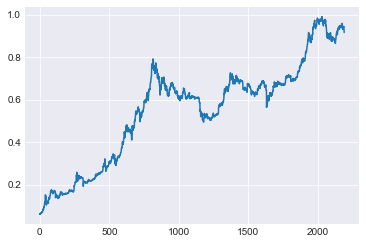

In [41]:
t = []
trainX_ = trainX[300:]
# t.append(trainX[0])
for i in range(len(trainX_)):
#     print(i%365)
    if i%365 == 0:
        t.append(trainX_[i])
t = np.array(t).reshape(-1,1)
plt.plot(t)

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

batch_size = 1024

earlystopping = EarlyStopping(monitor='loss', patience=200, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='loss', patience=30, factor=0.5, min_lr=0.000001)
checkpoint_full = ModelCheckpoint(filepath='my_best_model_v062.hdf5', monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks = [checkpoint_full, earlystopping, rlrop]

history_full = model.fit(trainX[300:], trainY[300:], batch_size = batch_size, epochs = 10000000, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

# checkpoint365 = ModelCheckpoint(filepath='my_best_model_365.hdf5', monitor='loss', verbose=1, save_best_only=True, mode='min')
# callbacks = [checkpoint365, earlystopping]
# history365 = regressor.fit(trainX[(len(trainY)-365):], trainY[(len(trainY)-365):], batch_size = batch_size, epochs = 50000, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/10000000


ResourceExhaustedError: Graph execution error:

Detected at node 'model/lstm/TensorArrayV2Stack/TensorListStack' defined at (most recent call last):
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\WEBFLAX-FOUR\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\WEBFLA~2\AppData\Local\Temp/ipykernel_21372/4201610947.py", line 10, in <module>
      history_full = model.fit(trainX[300:], trainY[300:], batch_size = batch_size, epochs = 10000000, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\layers\recurrent.py", line 679, in __call__
      return super(RNN, self).__call__(inputs, **kwargs)
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\layers\recurrent_v2.py", line 1159, in call
      last_output, outputs, states = backend.rnn(
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\backend.py", line 4751, in rnn
      outputs = tuple(o.stack() for o in output_ta)
    File "C:\Users\WEBFLAX-FOUR\AppData\Roaming\Python\Python39\site-packages\keras\backend.py", line 4751, in <genexpr>
      outputs = tuple(o.stack() for o in output_ta)
Node: 'model/lstm/TensorArrayV2Stack/TensorListStack'
OOM when allocating tensor with shape[282,1024,512] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node model/lstm/TensorArrayV2Stack/TensorListStack}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_10711]

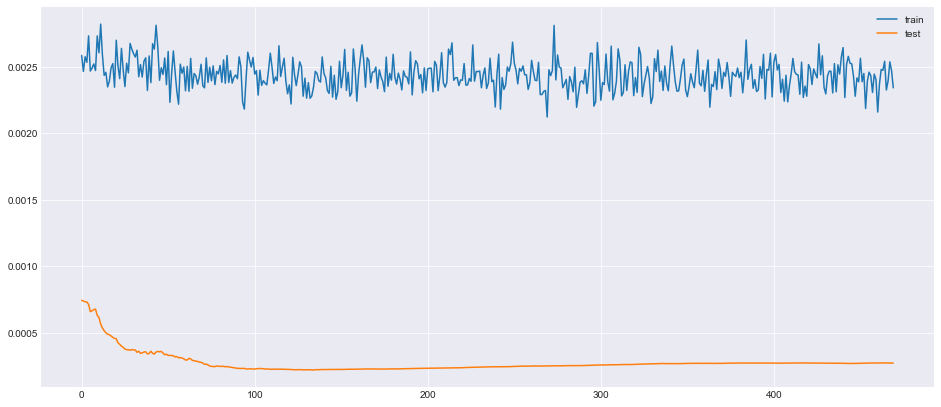

In [14]:
plt.figure(figsize=(16,7))
plt.plot(history_full.history['loss'], label='train')

plt.plot(history_full.history['val_loss'], label='test')
plt.legend()
plt.show()

In [14]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model('my_best_model_v062.hdf5')

# test test

In [13]:
# batch_size = 1


# model_from_saved_checkpoint = Sequential()


# model_from_saved_checkpoint.add(LSTM(units = 256, activation = 'relu', return_sequences=True, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True)) #  dropout=0.25, recurrent_dropout=0.1,
# model_from_saved_checkpoint.add(Dropout(0.2))

# model_from_saved_checkpoint.add(LSTM(units = 512, activation = 'relu', return_sequences=True, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True)) #  dropout=0.25, recurrent_dropout=0.1,
# model_from_saved_checkpoint.add(Dropout(0.3))

# model_from_saved_checkpoint.add(LSTM(units = 1024, activation = 'relu', return_sequences=True, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True)) #  dropout=0.25, recurrent_dropout=0.1,
# model_from_saved_checkpoint.add(Dropout(0.4))

# model_from_saved_checkpoint.add(LSTM(units = 128, activation = 'relu', batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True))
# model_from_saved_checkpoint.add(Dropout(0.2))


# model_from_saved_checkpoint.add(Dense(units = 32, activation = 'relu'))
# model_from_saved_checkpoint.add(Dropout(0.3))

# model_from_saved_checkpoint.add(Dense(units = 1))


# model_from_saved_checkpoint.load_weights('my_best_model_full.hdf5')
    
# model_from_saved_checkpoint.summary()



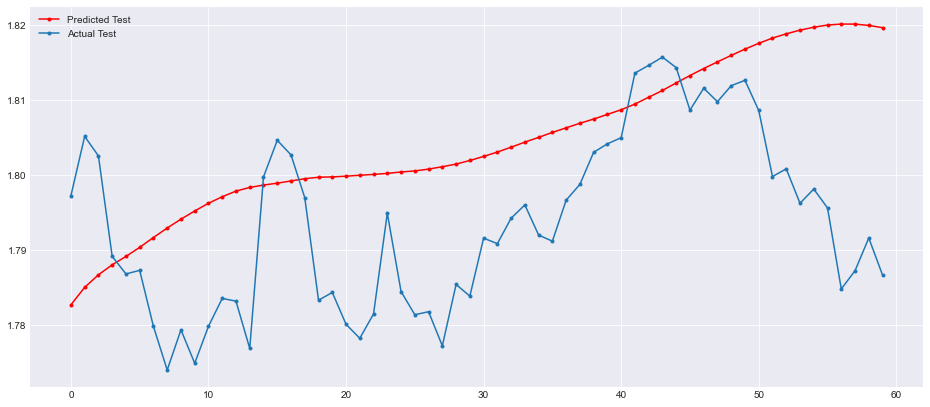

In [15]:
plt.figure(figsize=(16,7))

# log
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
predicted_btc_price_test_data = np.array(predicted_btc_price_test_data).reshape(-1, 1)
test_actual = testY.reshape(-1, 1)

plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')
plt.plot(test_actual, marker='.', label='Actual Test')

# # manoal
# predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
# predicted_btc_price_test_data = scaler_t.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))
# test_actual = scaler_t.inverse_transform(testY.reshape(-1, 1))

# plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')
# plt.plot(test_actual, marker='.', label='Actual Test')


plt.legend()
plt.show()

# test train

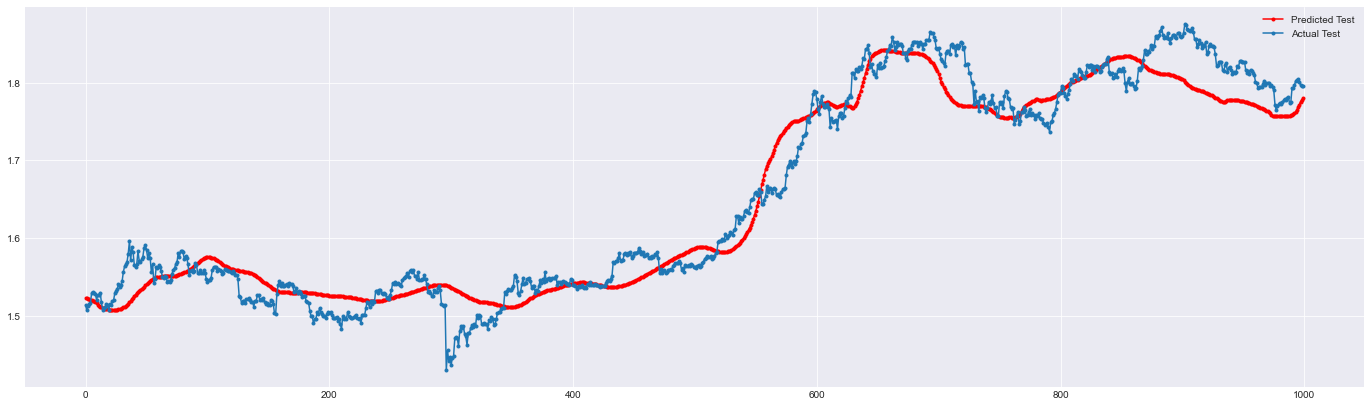

In [16]:
plt.figure(figsize=(24,7))

# log
predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX[-1000:])
predicted_btc_price_train_data = np.array(predicted_btc_price_train_data).reshape(-1, 1)
train_actual = np.array(trainY[-1000:]).reshape(-1, 1)

plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Test')
plt.plot(train_actual, marker='.', label='Actual Test')

# # manoal
# predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)
# predicted_btc_price_train_data = scaler_t.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))
# train_actual = scaler_t.inverse_transform(trainY.reshape(-1, 1))

# plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Test')
# plt.plot(train_actual, marker='.', label='Actual Test')


plt.legend()
plt.show()

# score

## log

In [ ]:
rmse_lstm_test = math.sqrt(mean_squared_error(np.exp(test_actual), np.exp(predicted_btc_price_test_data)))

print('Test RMSE: %.3f' % rmse_lstm_test)


Test RMSE: 2363.389


In [ ]:
rmse_lstm_train = math.sqrt(mean_squared_error(np.exp(train_actual), np.exp(predicted_btc_price_train_data)))

print('Train RMSE: %.3f' % rmse_lstm_train)


Train RMSE: 1764.024


## manoal

In [ ]:
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_btc_price_test_data))

print('Test RMSE: %.3f' % rmse_lstm_test)


Test RMSE: 2951.213


In [ ]:
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))

print('Train RMSE: %.3f' % rmse_lstm_train)


Test RMSE: 1503.741


# future

###### many to one

In [17]:
from collections import deque

# maxlen = 400
# c_log = deque(maxlen=maxlen)

# for i in range(-maxlen,0,1):
#   # prev_days.append(scaler.transform(test_actual[i].reshape(-1,1)))
#   c_log.append(look_b['close_log'].values[i])


SEQ_LEN=len(testX[-1])
prev_days = deque(maxlen=SEQ_LEN)

for i in range(-len(testX[-1]),0,1):
  # prev_days.append(scaler.transform(test_actual[i].reshape(-1,1)))
  prev_days.append(testX[-1][i])

In [18]:
np.array(col).reshape(-1,)

array(['close', 'close', 'target', 'target'], dtype='<U6')

In [19]:
y_p_ = []
future_len = 400
for i in range(future_len):
    x__ = np.array(prev_days).reshape(-1,len(np.array(prev_days)[-1])).astype(np.float32)

    per = model_from_saved_checkpoint.predict(np.expand_dims(x__, axis=0))

    prev_days.append(np.array(per).reshape(-1,1)) 

    y_p_.append(per.reshape(-1,1))


C:\Users\WEBFLA~2\AppData\Local\Temp/ipykernel_25756/969492449.py:4: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [20]:
# log
y_p_ = np.array(y_p_).reshape(-1, 1)
# manoal
# y_p_ = scaler_t.inverse_transform(np.array(y_p_).reshape(-1, 1))

###### plot future

In [21]:
future_actual = futureY.reshape(-1, 1)
actual = np.concatenate((train_actual,test_actual,future_actual))
predicted_btc_price = np.concatenate((predicted_btc_price_train_data, predicted_btc_price_test_data, np.array(y_p_).reshape(-1,1)), axis=0)

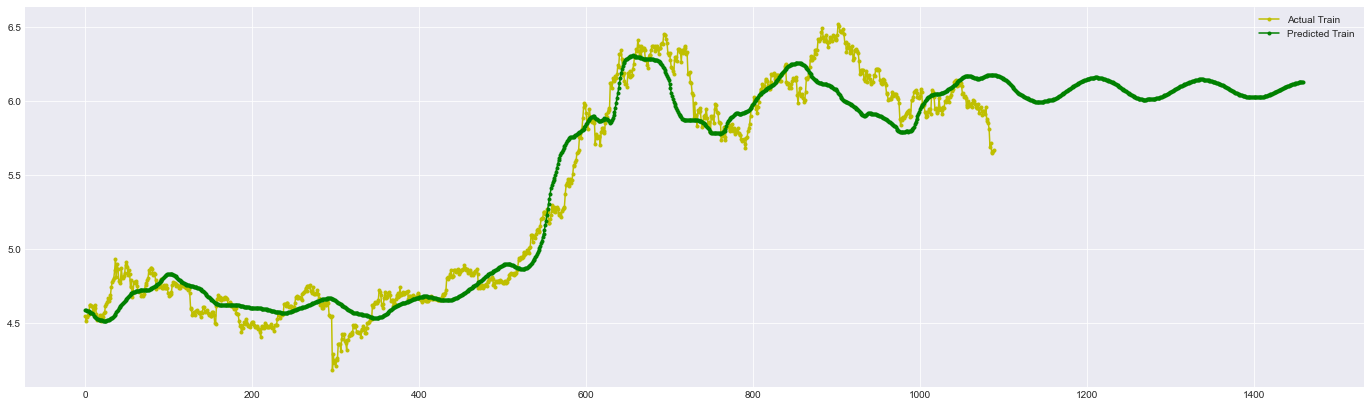

In [22]:
plt.figure(figsize=(24,7))

# log
plt.plot(np.exp(actual),'y', marker='.', label='Actual Train')
plt.plot(np.exp(predicted_btc_price), 'g', marker='.', label='Predicted Train')
# manoal
# plt.plot(actual,'y', marker='.', label='Actual Train')
# plt.plot(predicted_btc_price, 'g', marker='.', label='Predicted Train')


plt.legend()
plt.show()